In [45]:
 
!pip install -U tensorflow==2.11 # Keras 2


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [46]:

!pip install git+https://github.com/sebastian-sz/efficientnet-lite-keras@main


  Cloning https://github.com/sebastian-sz/efficientnet-lite-keras (to revision main) to /tmp/pip-req-build-zyaquuzg
  Running command git clone --filter=blob:none --quiet https://github.com/sebastian-sz/efficientnet-lite-keras /tmp/pip-req-build-zyaquuzg
  Resolved https://github.com/sebastian-sz/efficientnet-lite-keras to commit 728def97857d8aa83535d9275a1834c7df2316e9
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [47]:
import numpy as np
import pandas as pd
from glob import glob
import os
import pathlib
import tensorflow as tf
import keras

from keras.utils import  Sequence
from keras.models import Sequential
from tensorflow.keras.utils import img_to_array, load_img, to_categorical
#models
from efficientnet_lite import EfficientNetLiteB0, EfficientNetLiteB1, EfficientNetLiteB3

from sklearn.metrics import confusion_matrix
#preproces
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt

from collections import Counter
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score

import subprocess
from IPython.display import FileLink, display

In [48]:
tf.__version__, keras.__version__

('2.11.0', '2.11.0')

# Data Load

In [49]:

imgs = glob(r'/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/*/*')
labels = [el.split('/')[5] for el in imgs ]
SIZE = 345 #414

# Visualisation

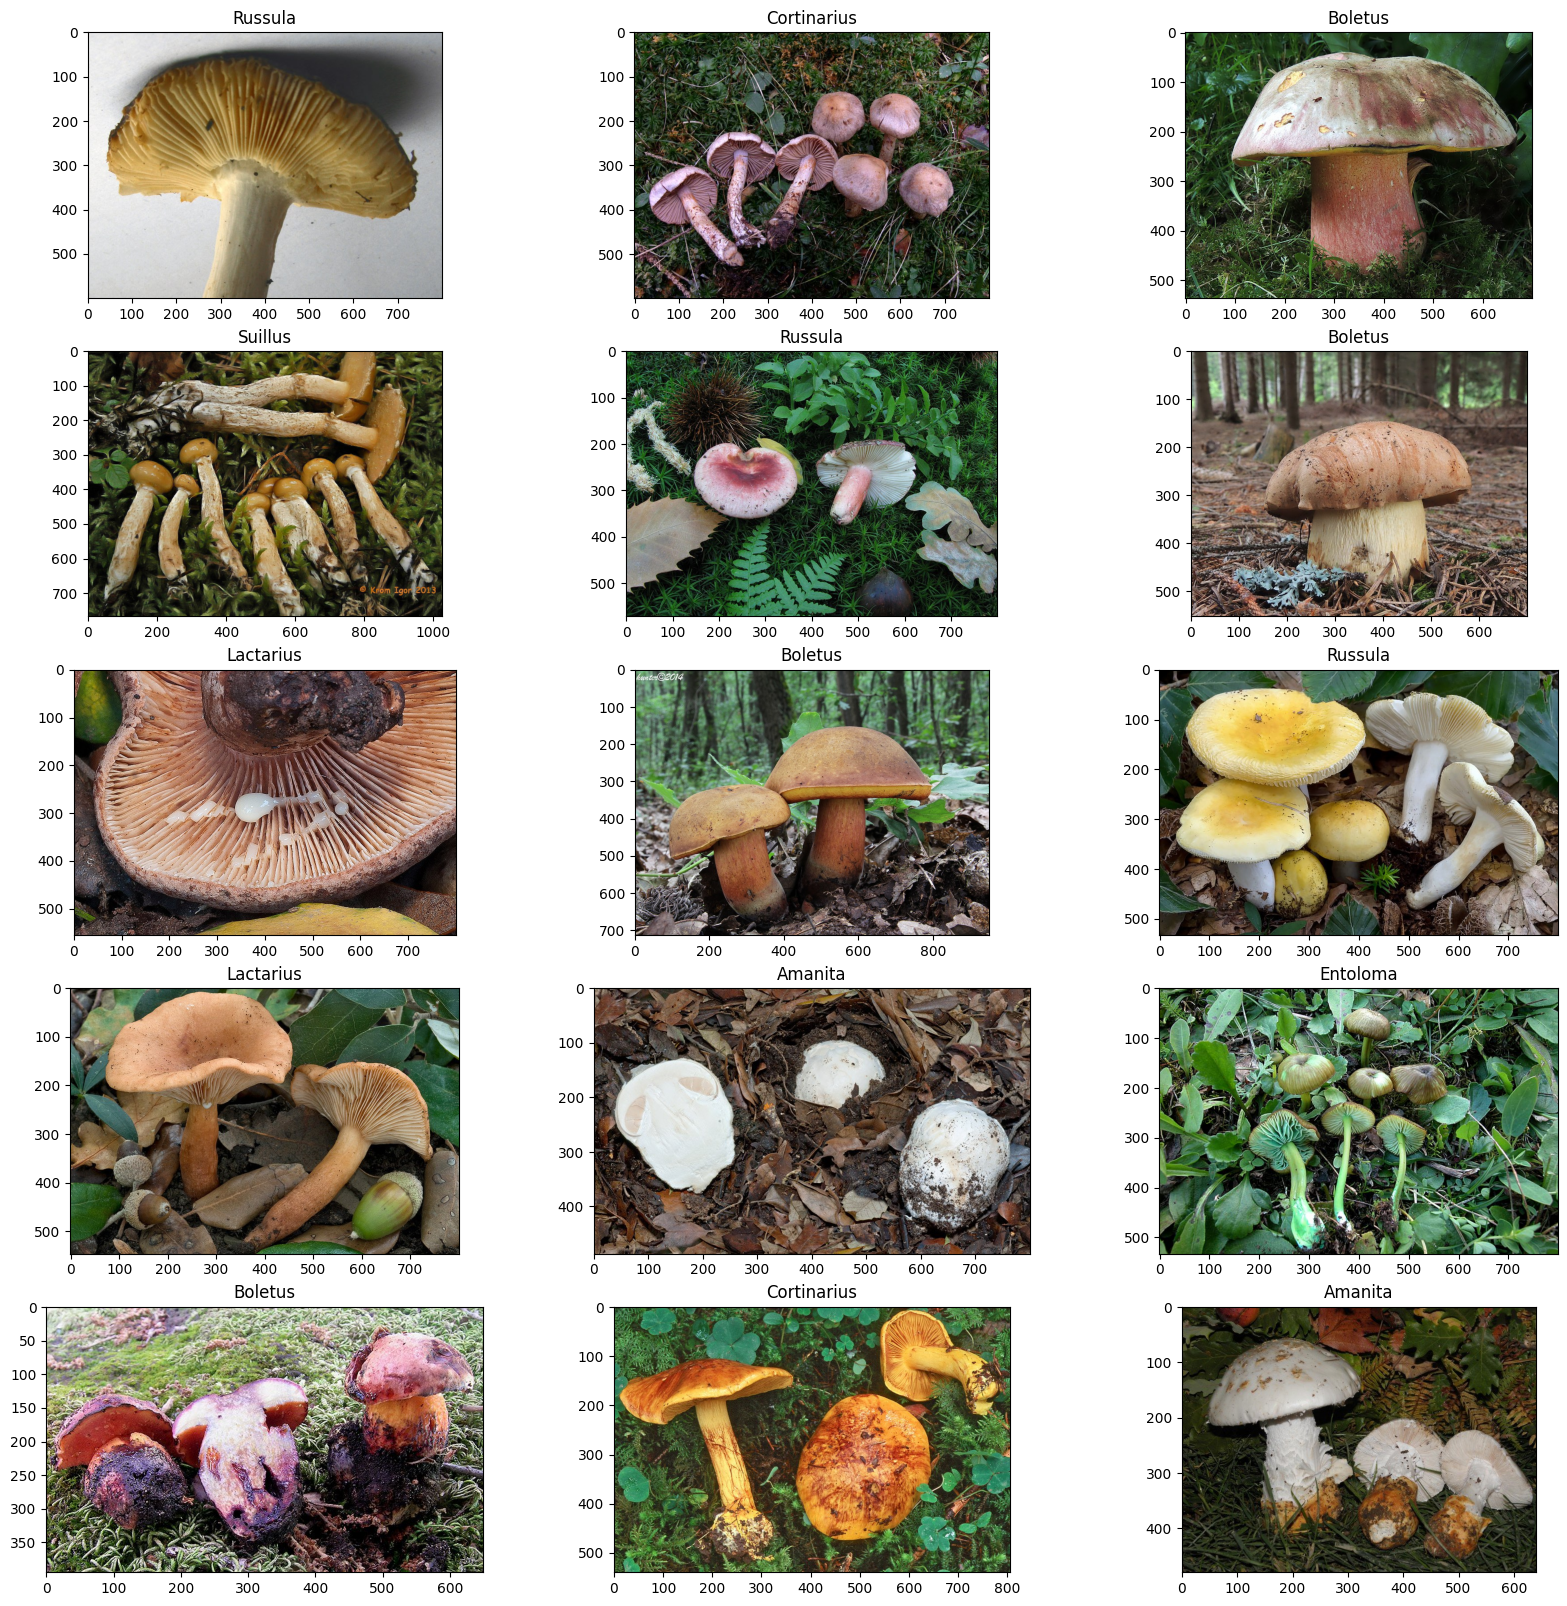

In [50]:

fig, ax = plt.subplots(5, 3, figsize=(20, 20))
fig.subplots_adjust()
im_list = np.random.choice(imgs, 15)
for axi, im in zip( ax.flat, im_list):
    axi.set_title(im.split('/')[5],)
    axi.imshow(plt.imread(im), )


## Class Distribution

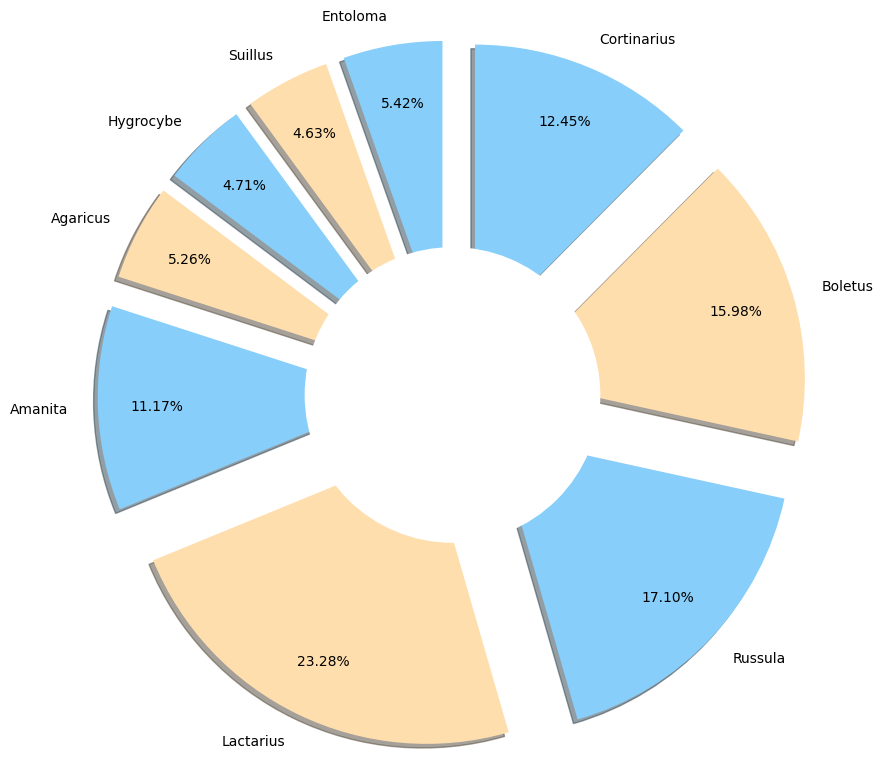

In [51]:

distribution_dict = {k:np.round(v*100/len(labels), 2) for k,v in Counter(labels).items()} 
distribution_dict = {k:np.round(v*100/len(labels), 2) for k,v in Counter(labels).items()} 
tab = {'lightskyblue': '#87CEFA', 'navajowhite': '#FFDEAD'}

plt.pie.DonutSize=9
plt.pie(distribution_dict.values(), labels=distribution_dict.keys(),radius=2, colors=tab, shadow=True, startangle=90, autopct='%1.2f%%',
       pctdistance=0.80, explode=[0.4 for el in range(9)])

hole = plt.Circle((0, 0), 1.0, facecolor='white')
plt.gcf().gca().add_artist(hole)
 
plt.show()

## Test Train Split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.3, random_state=1, stratify=labels)
train = pd.DataFrame(list(zip(X_train,y_train)), columns =['X','y'])
test = pd.DataFrame(list(zip(X_test,y_test)), columns =['X','y'])

In [53]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [54]:



datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True, 
        brightness_range=(1.05, 0.9),)
valid_gen = ImageDataGenerator(rescale=1./255)

In [55]:
train_gen = datagen.flow_from_dataframe(train, x_col='X', y_col="y", target_size=(SIZE, SIZE), interpolation='lanczos', shuffle=True)
test_gen = valid_gen.flow_from_dataframe(test, x_col='X', y_col="y", target_size=(SIZE, SIZE), interpolation='lanczos', )

Found 4699 validated image filenames belonging to 9 classes.
Found 2015 validated image filenames belonging to 9 classes.


# Build up EFB1 model

In [14]:
def build_model(num_classes=9):
    base_model = EfficientNetLiteB1( #B3
        input_shape=(SIZE,SIZE, 3),
        include_top=False,
        pooling="avg",
        weights="imagenet"
    )

    base_model.trainable=True

    return tf.keras.Sequential([
        base_model,
        
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.6), #0.6 0.7
        tf.keras.layers.Dense(210, activation="silu", kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l1(0.033)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation="softmax", kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l1(0.033))
    ])

In [15]:

model = build_model()

17242680/17242680 [==============================] - 0s 0us/step


In [16]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetlite1 (Function  (None, 1280)             4189344   
 al)                                                             
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 210)               269010    
                                                                 
 batch_normalization_1 (Batc  (None, 210)              840       
 hNormalization)                                                 
                                                        

In [18]:
def show_history(history):
    plt.figure(figsize=(18,8))

    plt.suptitle('Loss and Accuracy Plots', fontsize=18)

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.show()

In [18]:
loss = tf.keras.losses.CategoricalCrossentropy(
    
)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
 
model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3, restore_best_weights=True, start_from_epoch=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=0, min_lr=0.000001) #0



In [19]:

epoch = 10 # after more than 10 epoch tpu usually shut down 
history = model.fit(train_gen, validation_data=test_gen, epochs=epoch, callbacks=[early_stop, reduce_lr] )

Epoch 1/10
147/147 [==============================] - 551s 4s/step - loss: 56.8480 - accuracy: 0.4473 - val_loss: 10.4914 - val_accuracy: 0.4705 - lr: 0.0010
Epoch 2/10
147/147 [==============================] - 526s 4s/step - loss: 8.0012 - accuracy: 0.6065 - val_loss: 7.4774 - val_accuracy: 0.5102 - lr: 0.0010
Epoch 3/10
147/147 [==============================] - 519s 4s/step - loss: 6.9034 - accuracy: 0.6501 - val_loss: 7.0084 - val_accuracy: 0.6983 - lr: 0.0010
Epoch 4/10
147/147 [==============================] - 520s 4s/step - loss: 6.6668 - accuracy: 0.6838 - val_loss: 6.6577 - val_accuracy: 0.7062 - lr: 0.0010
Epoch 5/10
147/147 [==============================] - 517s 4s/step - loss: 6.6453 - accuracy: 0.7076 - val_loss: 7.0214 - val_accuracy: 0.6481 - lr: 0.0010
Epoch 6/10
147/147 [==============================] - 519s 4s/step - loss: 3.0185 - accuracy: 0.7834 - val_loss: 2.7854 - val_accuracy: 0.8084 - lr: 3.0000e-04
Epoch 7/10
147/147 [==============================] - 521s

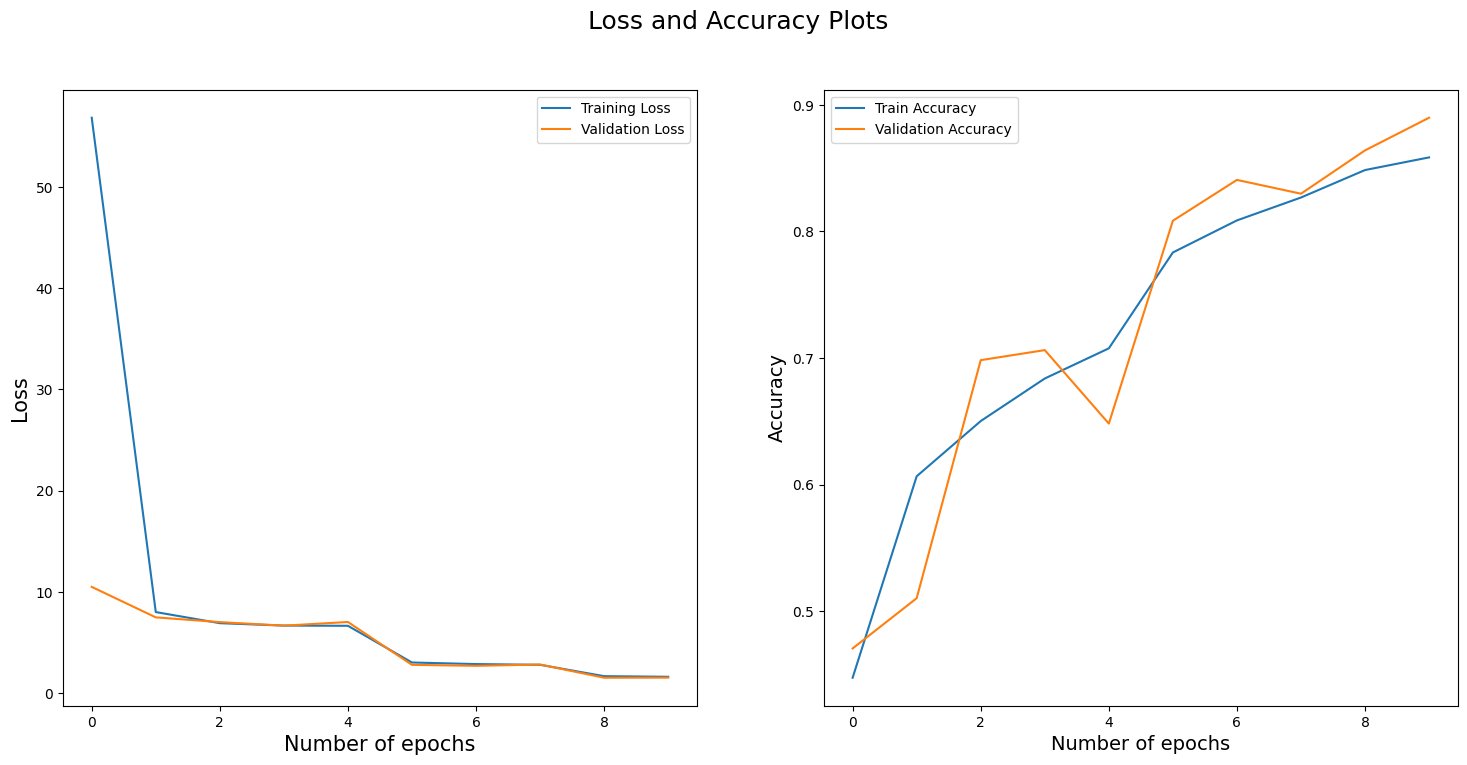

In [22]:
show_history(history)

In [23]:
model.save('mushroms_9_efb1_2012_t211.h5')

# Continue training

In [14]:
model = keras.models.load_model('/kaggle/input/m9_efb1_2012/tensorflow2/m9/1/mushroms_9_efb1_2012_t211.h5')

In [16]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1.0000e-06)
 
model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3, restore_best_weights=True, start_from_epoch=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=0, min_lr=1.0000e-08) #0
epoch = 7
history = model.fit(train_gen, validation_data=test_gen, epochs=epoch, callbacks=[early_stop, reduce_lr] )

Epoch 1/7
147/147 [==============================] - 551s 4s/step - loss: 1.2478 - accuracy: 0.8834 - val_loss: 1.0763 - val_accuracy: 0.8923 - lr: 1.0000e-06
Epoch 2/7
147/147 [==============================] - 524s 4s/step - loss: 1.1280 - accuracy: 0.8766 - val_loss: 1.0237 - val_accuracy: 0.8953 - lr: 1.0000e-06
Epoch 3/7
147/147 [==============================] - 524s 4s/step - loss: 1.0946 - accuracy: 0.8821 - val_loss: 1.0073 - val_accuracy: 0.8943 - lr: 1.0000e-06
Epoch 4/7
147/147 [==============================] - 522s 4s/step - loss: 1.1030 - accuracy: 0.8732 - val_loss: 0.9972 - val_accuracy: 0.8948 - lr: 1.0000e-06
Epoch 5/7
147/147 [==============================] - 524s 4s/step - loss: 1.0934 - accuracy: 0.8751 - val_loss: 0.9934 - val_accuracy: 0.8963 - lr: 1.0000e-06
Epoch 6/7
147/147 [==============================] - 522s 4s/step - loss: 1.0917 - accuracy: 0.8768 - val_loss: 0.9907 - val_accuracy: 0.8948 - lr: 1.0000e-06
Epoch 7/7
147/147 [===========================

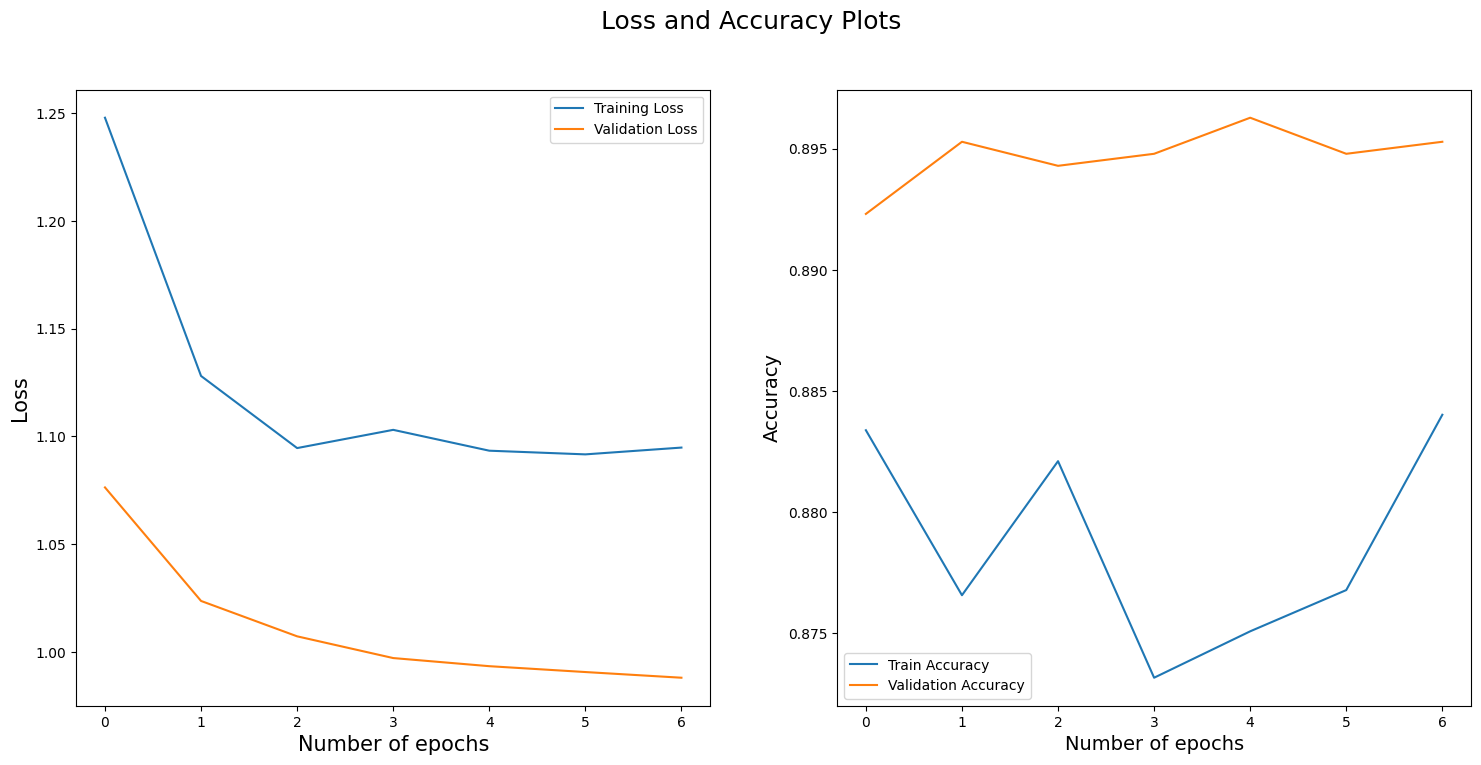

In [19]:
show_history(history)

## Metrics

In [23]:
val = model.evaluate(test_gen)
test = model.evaluate(train_gen)


147/147 [==============================] - 234s 2s/step - loss: 0.8446 - accuracy: 0.9487


## Saving the model

In [52]:
model.save('mushroms_9_efb1_2012_2_t211.h5')

## TF lite saving

In [53]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpjz3prbvx/assets


INFO:tensorflow:Assets written to: /tmp/tmpjz3prbvx/assets


In [54]:
import pathlib
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

17567060

## Conclusion
accuracy: 0.8953 on val data.  
model - EfficientNetLiteB1  
IMG SIZE - 345  
interpolation - lancos  

Lanczos -  is a sophisticated technique for interpolating digital signals, offering superior image quality compared to simpler methods like nearest neighbor and bilinear interpolation. By effectively preserving detail and minimizing aliasing artifacts, Lanczos resampling is widely used in image and signal processing applications.

To achieve accuracy near 90 % I use lancos for interpolations param. In others attempts for models from EfficientNetLiteB0 to EfficientNetLiteB3 and IMG size from 224 to 400 accuracy didn't secede 82% on val data